<h1 style="color:#2E86C1; text-align:center;"> Grouping & Aggregation Analysis
</h1>



<h2 style="color:#117A65;">🔹 Step 1: Import Libraries</h2>

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)


def style_table(df, bg_color="#20B2AA"):
    return (
        df.style
        .set_table_styles([
            {"selector": "th",
             "props": [("background-color", bg_color),
                       ("color", "white"),
                       ("border", "1px solid black"),
                       ("padding", "8px"),
                       ("font-weight", "bold")]},
            {"selector": "td",
             "props": [("border", "1px solid #34495E"),
                       ("padding", "8px")]}
        ])
        .set_properties(**{"text-align": "center"})
    )


def small_summary_table(d: dict, bg_color="#20B2AA"):
    df_sum = pd.DataFrame([d])
    return style_table(df_sum, bg_color=bg_color)


<h2 style="color:#117A65;">🔹 Step 2: Load Dataset</h2>

In [39]:
# Attempt to load Superstore Sales
sales_url = "https://raw.githubusercontent.com/yannie28/Global-Superstore/master/Global_Superstore(CSV).csv"

loaded_dataset = None
try:
    df = pd.read_csv(sales_url, encoding="latin1")
    loaded_dataset = "superstore"
except Exception as e:
    import seaborn as sns
    df = sns.load_dataset("tips")
    loaded_dataset = "tips"

summary_msg = {
    "Dataset Used": "Global Superstore (Sales)" if loaded_dataset == "superstore" else "Seaborn Tips (Survey-like)",
    "Rows": df.shape[0],
    "Columns": df.shape[1],
    "Missing Values": int(df.isna().sum().sum())
}
display(small_summary_table(summary_msg))


,Dataset Used,Rows,Columns,Missing Values
0,Global Superstore (Sales),1000,24,806


<h2 style="color:#117A65;">🔹 Step 3: DataSet Overview</h2>

In [40]:
display(style_table(df.head()))


,ï»¿Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,40098,CA-2014-AB10015140-41954,11/11/2014,11/13/2014,First Class,AB-100151402,Aaron Bergman,Consumer,73120.000000,Oklahoma City,Oklahoma,United States,Central US,USCA,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.980000,2,0.000000,62.150000,40.770000,High
1,26341,IN-2014-JR162107-41675,2/5/2014,2/7/2014,Second Class,JR-162107,Justin Ritter,Corporate,nan,Wollongong,New South Wales,Australia,Oceania,Asia Pacific,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.400000,9,0.100000,-288.770000,923.630000,Critical
2,25330,IN-2014-CR127307-41929,10/17/2014,10/18/2014,First Class,CR-127307,Craig Reiter,Consumer,nan,Brisbane,Queensland,Australia,Oceania,Asia Pacific,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.170000,9,0.100000,919.970000,915.490000,Medium
3,13524,ES-2014-KM1637548-41667,1/28/2014,1/30/2014,First Class,KM-1637548,Katherine Murray,Home Office,nan,Berlin,Berlin,Germany,Western Europe,Europe,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510000,5,0.100000,-96.540000,910.160000,Medium
4,47221,SG-2014-RH9495111-41948,11/5/2014,11/6/2014,Same Day,RH-9495111,Rick Hansen,Consumer,nan,Dakar,Dakar,Senegal,Western Africa,Africa,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960000,8,0.000000,311.520000,903.040000,Critical


<h2 style="color:#117A65;">🔹 Step 4 : Prepare fields  </h2>


In [41]:
if loaded_dataset == "superstore":
    df.columns = [c.strip() for c in df.columns]


    for c in ["Order Date", "Ship Date"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")


    if "Order Date" in df.columns:
        df["YearMonth"] = df["Order Date"].dt.to_period("M").astype("string")


dtypes_df = pd.DataFrame(df.dtypes, columns=["dtype"]).reset_index().rename(columns={"index": "column"})
display(style_table(dtypes_df))


,column,dtype
0,ï»¿Row ID,int64
1,Order ID,object
2,Order Date,datetime64[ns]
3,Ship Date,datetime64[ns]
4,Ship Mode,object
5,Customer ID,object
6,Customer Name,object
7,Segment,object
8,Postal Code,float64
9,City,object


<h2 style="color:#117A65;">🔹 Step 5: Grouping & Aggregations

 computing:
- **Sales by Region** (sum)  
- **Profit by Segment** (mean)  
- **Sales & Profit by Category** (sum)  
- **Top 10 Sub-Categories by Sales**  
- **Orders by Ship Mode** (count)

If fallback dataset (Tips) is in use, we compute analogous survey-style groupings:
- **Total bill by day**  
- **Average tip by sex**  
- **Counts by smoker status**  
- **Average total bill by time & day**</h2>

In [42]:
results = {}

if loaded_dataset == "superstore":
    have = set(df.columns)


    if {"Region", "Sales"} <= have:
        sales_by_region = df.groupby("Region", dropna=False)["Sales"].sum().reset_index()
        results["sales_by_region"] = sales_by_region


    if {"Segment", "Profit"} <= have:
        profit_by_segment = df.groupby("Segment", dropna=False)["Profit"].mean().reset_index()
        results["profit_by_segment"] = profit_by_segment


    if {"Category", "Sales", "Profit"} <= have:
        category_summary = (
            df.groupby("Category", dropna=False)
              .agg(Sales=("Sales", "sum"), Profit=("Profit", "sum"))
              .reset_index()
        )
        results["category_summary"] = category_summary


    if {"Sub-Category", "Sales"} <= have:
        top_subcat = (df.groupby("Sub-Category", dropna=False)["Sales"]
                        .sum().reset_index()
                        .sort_values("Sales", ascending=False)
                        .head(10))
        results["top_subcat"] = top_subcat


    if {"Ship Mode", "Order ID"} <= have:
        orders_by_shipmode = (
            df.groupby("Ship Mode", dropna=False)["Order ID"]
              .nunique().reset_index()
              .rename(columns={"Order ID": "Orders"})
        )
        results["orders_by_shipmode"] = orders_by_shipmode

else:
    total_by_day = df.groupby("day", dropna=False)["total_bill"].sum().reset_index()
    results["total_by_day"] = total_by_day


    tip_by_sex = df.groupby("sex", dropna=False)["tip"].mean().reset_index()
    results["tip_by_sex"] = tip_by_sex


    count_by_smoker = df.groupby("smoker", dropna=False)["total_bill"].count().reset_index().rename(columns={"total_bill": "count"})
    results["count_by_smoker"] = count_by_smoker


    bill_by_time_day = (
        df.groupby(["time", "day"], dropna=False)["total_bill"]
          .mean().reset_index()
    )
    results["bill_by_time_day"] = bill_by_time_day


for name, table in results.items():
    display(HTML(f"<h4 style='color:#1F618D'>{name.replace('_',' ').title()}</h4>"))
    display(style_table(table))


,Region,Sales
0,Canada,887.010000
1,Caribbean,30746.740000
2,Central Africa,33810.480000
3,Central America,140966.210000
4,Central US,17187.940000
5,Eastern Africa,17387.940000
6,Eastern Asia,193590.600000
7,Eastern Europe,45662.190000
8,Eastern US,12256.440000
9,North Africa,26266.440000


,Segment,Profit
0,Consumer,313.329960
1,Corporate,296.337933
2,Home Office,214.294513


,Category,Sales,Profit
0,Furniture,601492.310000,82188.950000
1,Office Supplies,352496.140000,61662.810000
2,Technology,756983.020000,145068.680000


,Sub-Category,Sales
13,Phones,417939.310000
1,Appliances,289711.300000
4,Bookcases,240688.730000
6,Copiers,231104.670000
5,Chairs,179648.440000
16,Tables,179292.880000
11,Machines,71366.870000
14,Storage,37592.320000
0,Accessories,36572.170000
3,Binders,19751.190000


,Ship Mode,Orders
0,First Class,266
1,Same Day,89
2,Second Class,213
3,Standard Class,299


<h2 style="color:#117A65;">🔹 Step 6: Visualizations of Grouped Results</h2>

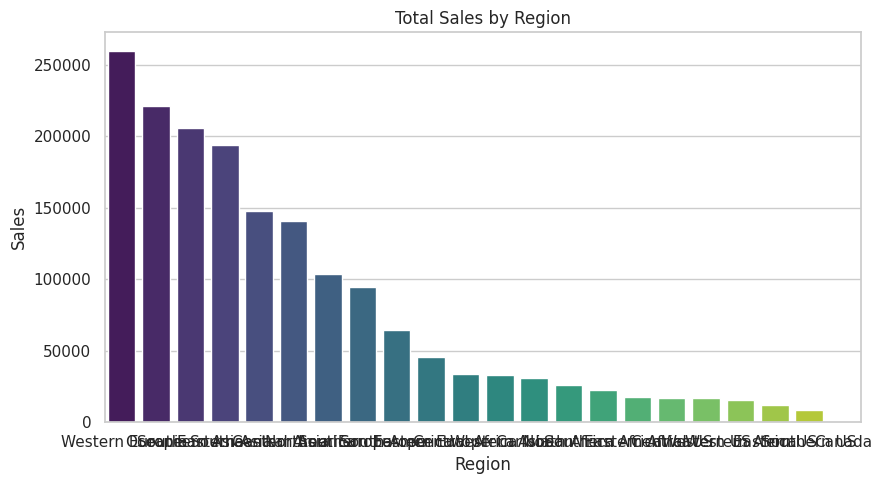

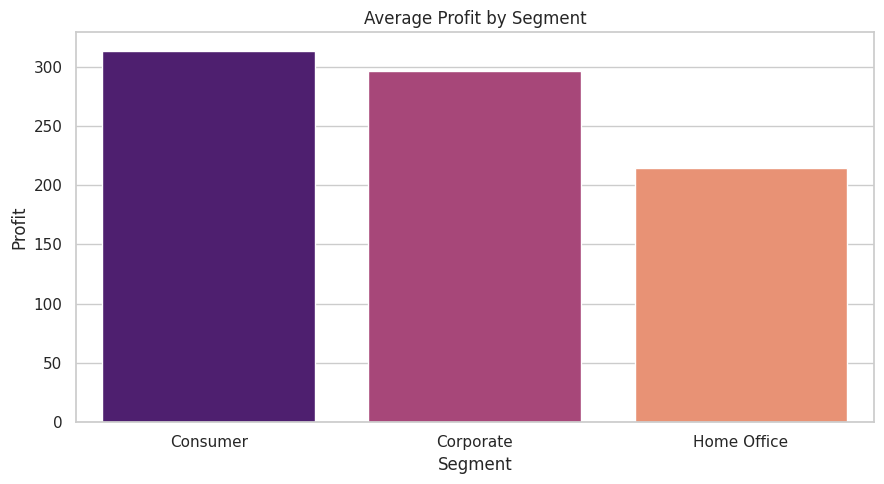

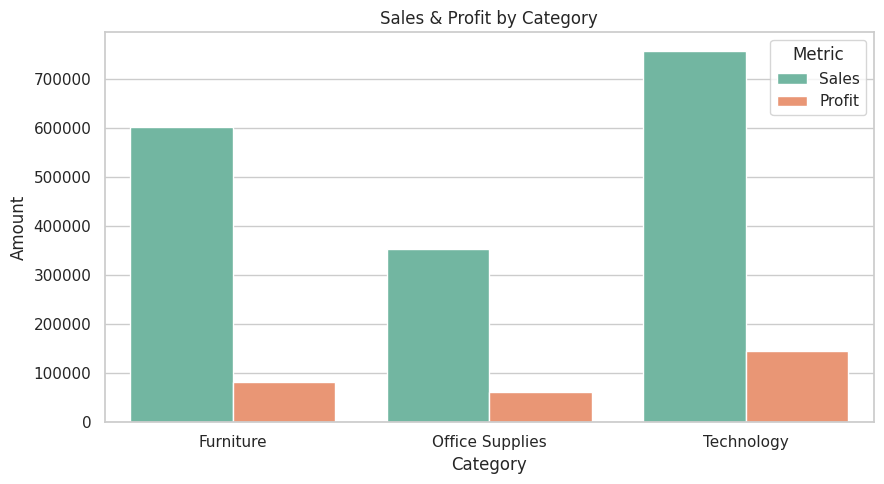

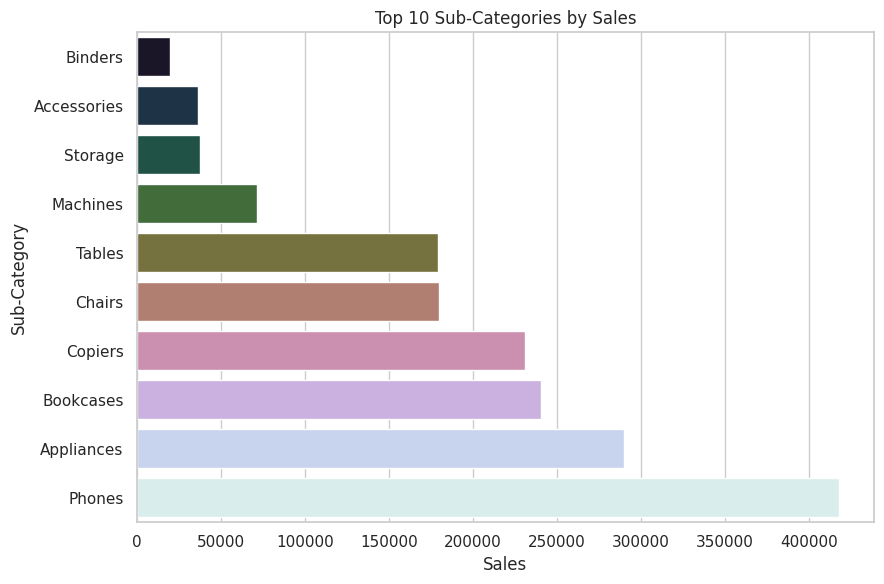

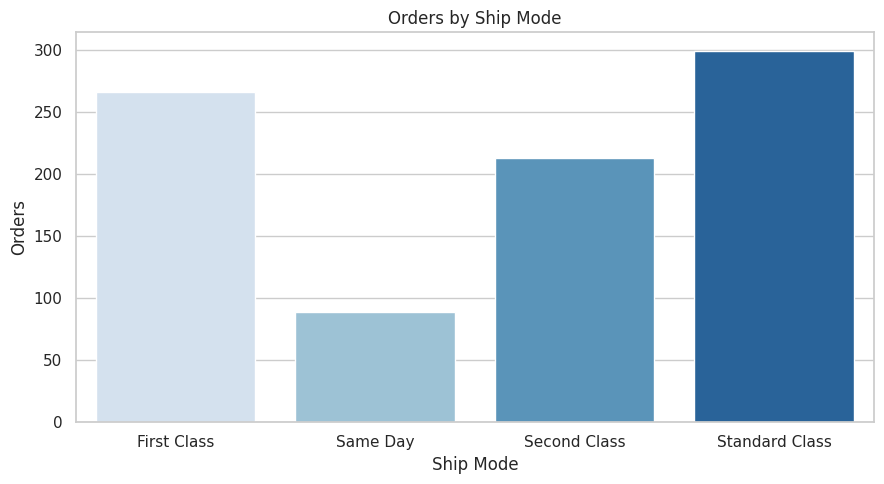

Category,Region,Furniture,Office Supplies,Technology
0,Canada,0.000000,887.010000,0.000000
1,Caribbean,12935.220000,7971.200000,9840.320000
2,Central Africa,13578.480000,3129.480000,17102.520000
3,Central America,43213.840000,25707.020000,72045.350000
4,Central US,2085.150000,12231.040000,2871.750000
5,Eastern Africa,3989.160000,4819.980000,8578.800000
6,Eastern Asia,76786.810000,29599.250000,87204.540000
7,Eastern Europe,20589.990000,8371.440000,16700.760000
8,Eastern US,3258.530000,7326.560000,1671.350000
9,North Africa,5496.120000,5744.880000,15025.440000


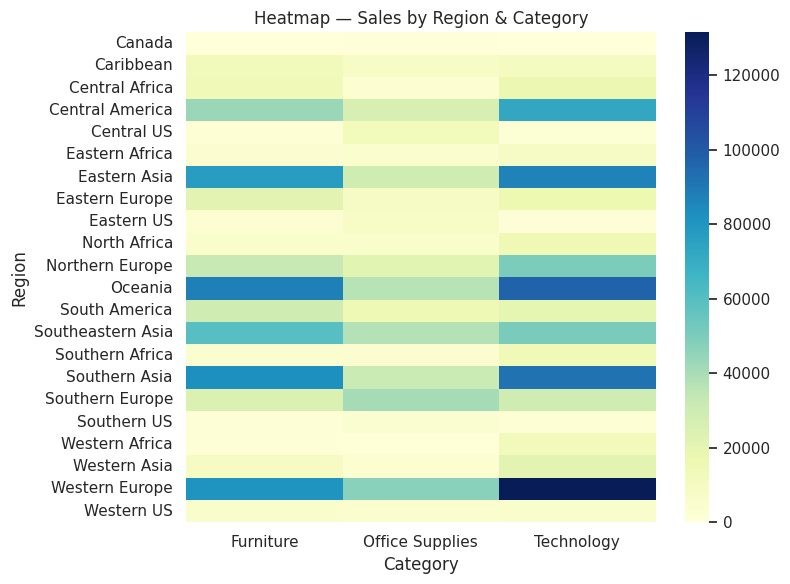

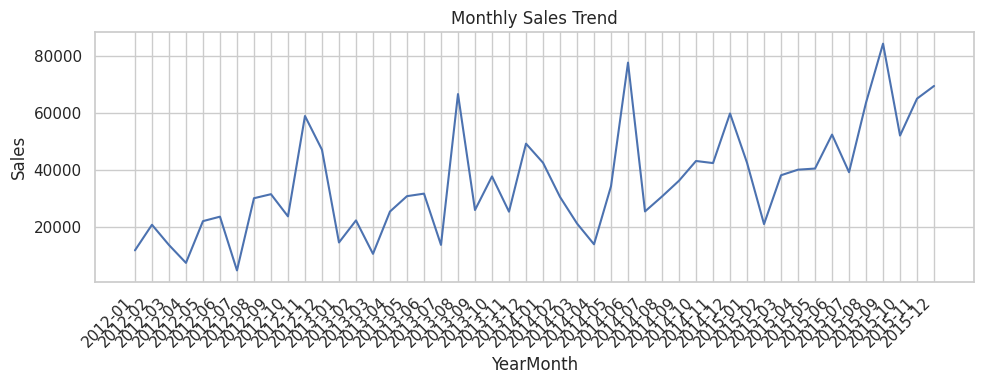

In [46]:
if loaded_dataset == "superstore":

    if "sales_by_region" in results:
        plot_df = results["sales_by_region"].sort_values("Sales", ascending=False)
        plt.figure()
        sns.barplot(
            data=plot_df, x="Region", y="Sales",
            hue="Region", palette="viridis", legend=False
        )
        plt.title("Total Sales by Region")
        plt.tight_layout()
        plt.show()

    if "profit_by_segment" in results:
        plt.figure()
        sns.barplot(
            data=results["profit_by_segment"], x="Segment", y="Profit",
            hue="Segment", palette="magma", legend=False
        )
        plt.title("Average Profit by Segment")
        plt.tight_layout()
        plt.show()

    if "category_summary" in results:
        melted = results["category_summary"].melt(
            id_vars="Category", value_vars=["Sales", "Profit"],
            var_name="Metric", value_name="Value"
        )
        plt.figure()
        sns.barplot(data=melted, x="Category", y="Value", hue="Metric", palette="Set2")
        plt.title("Sales & Profit by Category")
        plt.ylabel("Amount")
        plt.tight_layout()
        plt.show()

    if "top_subcat" in results:
        plot_df = results["top_subcat"].sort_values("Sales", ascending=True)
        plt.figure(figsize=(9, 6))
        sns.barplot(
            data=plot_df, y="Sub-Category", x="Sales",
            hue="Sub-Category", palette="cubehelix", legend=False
        )
        plt.title("Top 10 Sub-Categories by Sales")
        plt.tight_layout()
        plt.show()

    if "orders_by_shipmode" in results:
        plt.figure()
        sns.barplot(
            data=results["orders_by_shipmode"], x="Ship Mode", y="Orders",
            hue="Ship Mode", palette="Blues", legend=False
        )
        plt.title("Orders by Ship Mode")
        plt.tight_layout()
        plt.show()

    if {"Region", "Category", "Sales"} <= set(df.columns):
        pivot_sales = pd.pivot_table(
            df, index="Region", columns="Category",
            values="Sales", aggfunc="sum", fill_value=0
        )
        display(HTML("<h4 style='color:#1F618D'>Sales Pivot (Region x Category)</h4>"))
        display(style_table(pivot_sales.reset_index()))
        plt.figure(figsize=(8, 6))
        sns.heatmap(pivot_sales, annot=False, cmap="YlGnBu")
        plt.title("Heatmap — Sales by Region & Category")
        plt.tight_layout()
        plt.show()

    if "YearMonth" in df.columns and "Sales" in df.columns:
        trend = df.groupby("YearMonth", dropna=False)["Sales"].sum().reset_index()
        trend = trend.sort_values("YearMonth")
        plt.figure(figsize=(10, 4))
        sns.lineplot(data=trend, x="YearMonth", y="Sales")
        plt.title("Monthly Sales Trend")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

else:
    if "total_by_day" in results:
        plt.figure()
        sns.barplot(
            data=results["total_by_day"], x="day", y="total_bill",
            hue="day", palette="viridis", legend=False
        )
        plt.title("Total Bill by Day")
        plt.tight_layout()
        plt.show()

    if "tip_by_sex" in results:
        plt.figure()
        sns.barplot(
            data=results["tip_by_sex"], x="sex", y="tip",
            hue="sex", palette="magma", legend=False
        )
        plt.title("Average Tip by Sex")
        plt.tight_layout()
        plt.show()

    if "count_by_smoker" in results:
        plt.figure()
        sns.barplot(
            data=results["count_by_smoker"], x="smoker", y="count",
            hue="smoker", palette="Set2", legend=False
        )
        plt.title("Counts by Smoker Status")
        plt.tight_layout()
        plt.show()

    if "bill_by_time_day" in results:
        plt.figure()
        sns.barplot(data=results["bill_by_time_day"], x="day", y="total_bill", hue="time", palette="Set3")
        plt.title("Average Total Bill by Time & Day")
        plt.tight_layout()
        plt.show()


<h2 style="color:#117A65;">🔹 Step 7: Insights </h2>

In [44]:
if loaded_dataset == "superstore":
    insights = pd.DataFrame({
        "Insight": [
            "Regions show clear sales spread — prioritize high-performing regions while diagnosing low performers.",
            "Consumer segment often yields strong average profit; tailor promos/assortment per segment.",
            "Technology category tends to drive higher totals; review Furniture margins and discounting.",
            "Top sub-categories concentrate revenue — focus inventory & marketing accordingly.",
            "Standard Ship Mode usually dominates order volume — opportunity to optimize logistics costs."
        ]
    })
else:
    insights = pd.DataFrame({
        "Insight": [
            "Total bill varies by day — weekend behavior differs from weekdays.",
            "Average tip differs by gender; consider service/staffing insights.",
            "Smoker vs non-smoker counts show distinct composition.",
            "Evening meals (Dinner) tend to have higher spend than Lunch."
        ]
    })

display(style_table(insights, bg_color="#117A65"))


,Insight
0,Regions show clear sales spread — prioritize high-performing regions while diagnosing low performers.
1,Consumer segment often yields strong average profit; tailor promos/assortment per segment.
2,Technology category tends to drive higher totals; review Furniture margins and discounting.
3,Top sub-categories concentrate revenue — focus inventory & marketing accordingly.
4,Standard Ship Mode usually dominates order volume — opportunity to optimize logistics costs.
